Original Model:
The ENPV without converting to drip irrigation is $6453.9/ha
The ENPV with converting to drip irrigation is $7909.1/ha
The option value of switching to drip irrigation is $1455.2/ha


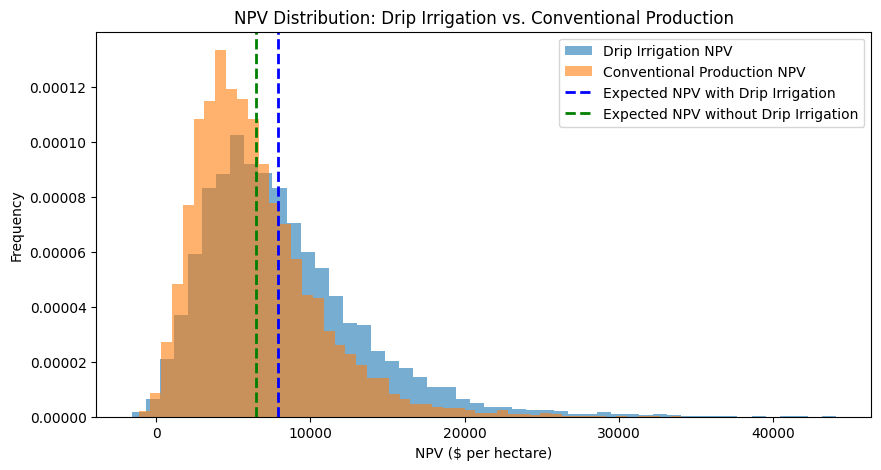


With 30% Yield Volatility (Common Yield Factor):
The ENPV without converting to drip irrigation is $6471.0/ha
The ENPV with converting to drip irrigation is $7796.1/ha
The option value of switching to drip irrigation is $1325.1/ha


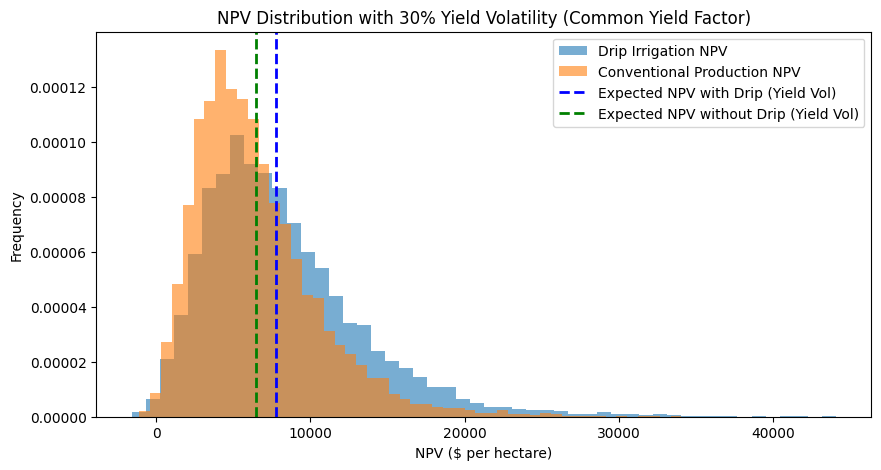

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model


# UPDATED SIMULATION PARAMETERS
T = 10              # Project duration in years
n_sim = 10000       # Number of Monte Carlo simulations
r = 0.02            # Discount rate (2%)

# Cotton market parameters
crop_price_0 = 1950         # Initial cotton price per ton ($)
crop_price_sigma = 0.20     # Implied volatility (18%)

# Drip irrigation system parameters (per hectare)
drip_opex_0 = 686           # Initial operating cost ($/ha)
drip_opex_decline = 0.98    # Annual decline rate (i.e., cost declines by 2% per year)
drip_yield_increase = 0.3   # Additional yield with drip irrigation (30% increase)
capex_drip = 1941           # Upfront CAPEX for drip irrigation per hectare ($)

# Conventional irrigation system parameters (per hectare)
conv_opex_0 = 600           # Initial operating cost ($/ha)
conv_opex_increase = 1.02   # Annual increase rate (2% increase per year)

# Tax rate
tax_rate = 0.12

# Baseline yield assumptions (in ton/ha) without yield shocks
baseline_yield_conv = 0.752                    # Conventional yield (ton/ha)
baseline_yield_drip = baseline_yield_conv * (1 + drip_yield_increase)  # Drip irrigation yield (ton/ha)

# Investment decision year (when conversion to drip is evaluated)
invest_year = 5

rng = np.random.RandomState(1)
crop_price = np.c_[np.ones((n_sim, 1)) * crop_price_0, np.empty([n_sim, T - 1])]
for t in range(1, T):
    crop_price[:, t] = crop_price[:, t - 1] * np.exp(-0.5 * (crop_price_sigma**2)
                                                       + crop_price_sigma * rng.randn(n_sim))
# Drip irrigation operating cost: deterministic decline
drip_opex = np.full((n_sim, T), drip_opex_0, dtype=float)
for t in range(1, T):
    drip_opex[:, t] = drip_opex[:, t - 1] * drip_opex_decline

# Conventional irrigation operating cost: deterministic increase
conv_opex = np.full((n_sim, T), conv_opex_0, dtype=float)
for t in range(1, T):
    conv_opex[:, t] = conv_opex[:, t - 1] * conv_opex_increase

# Revenue = Crop price × yield (per hectare) using constant yield (baseline)
revenue_conv = crop_price * baseline_yield_conv
revenue_drip = crop_price * baseline_yield_drip

# Operating profit = Revenue minus operating cost
profit_conv = revenue_conv - conv_opex
profit_drip = revenue_drip - drip_opex

# Tax on operating profits
tax_conv = tax_rate * profit_conv
tax_drip = tax_rate * profit_drip

# After-tax cash flows (ATCF)
atcf_conv = profit_conv - tax_conv
atcf_drip = profit_drip - tax_drip

# Discount factors for each year
dis_fact = np.array([(1 + r) ** (-i - 1) for i in range(T)])

# Compute NPV for each simulation
npv_conv = (atcf_conv * dis_fact).sum(axis=1)
npv_drip = (atcf_drip * dis_fact).sum(axis=1) - capex_drip

# Regression to use at invest_year as a proxy for future performance.
X = np.c_[crop_price[:, invest_year], drip_opex[:, invest_year]]
regr = linear_model.LinearRegression()
regr.fit(X, npv_drip)
cv_pred = regr.predict(X)

invest = cv_pred > npv_conv
enpv_with_drip = np.mean(np.where(invest, npv_drip, npv_conv))
enpv_without_drip = np.mean(npv_conv)
option_value = enpv_with_drip - enpv_without_drip

print("Original Model:")
print("The ENPV without converting to drip irrigation is $%.1f/ha" % enpv_without_drip)
print("The ENPV with converting to drip irrigation is $%.1f/ha" % enpv_with_drip)
print("The option value of switching to drip irrigation is $%.1f/ha" % option_value)

plt.figure(figsize=(10, 5))
plt.hist(npv_drip, bins=50, alpha=0.6, density=True, label='Drip Irrigation NPV')
plt.hist(npv_conv, bins=50, alpha=0.6, density=True, label='Conventional Production NPV')
plt.axvline(enpv_with_drip, color='b', linestyle='dashed', linewidth=2,
            label='Expected NPV with Drip Irrigation')
plt.axvline(enpv_without_drip, color='g', linestyle='dashed', linewidth=2,
            label='Expected NPV without Drip Irrigation')
plt.legend()
plt.xlabel('NPV ($ per hectare)')
plt.ylabel('Frequency')
plt.title('NPV Distribution: Drip Irrigation vs. Conventional Production')
plt.show()

# Incorporating 30% Yield Volatility

# The yield variability is modeled as a common random yield factor affecting both methods.
yield_vol = 0.30  # 30% yield volatility

# Simulate common yield factors for each simulation and each time period.
common_yield_factor = np.exp(-0.5 * (yield_vol**2) + yield_vol * rng.randn(n_sim, T))

# Now, both methods are affected by the same yield shocks:
yield_conv_path = baseline_yield_conv * common_yield_factor
yield_drip_path = baseline_yield_drip * common_yield_factor  # drip yield is always 30% higher than baseline

# Compute revenues with yield volatility.
revenue_conv_vol = crop_price * yield_conv_path
revenue_drip_vol = crop_price * yield_drip_path

# Compute operating profits with yield volatility.
profit_conv_vol = revenue_conv_vol - conv_opex
profit_drip_vol = revenue_drip_vol - drip_opex

# Compute tax on operating profits.
tax_conv_vol = tax_rate * profit_conv_vol
tax_drip_vol = tax_rate * profit_drip_vol

# After-tax cash flows (ATCF) with yield volatility.
atcf_conv_vol = profit_conv_vol - tax_conv_vol
atcf_drip_vol = profit_drip_vol - tax_drip_vol

# Compute NPVs for each simulation with yield volatility.
npv_conv_vol = (atcf_conv_vol * dis_fact).sum(axis=1)
npv_drip_vol = (atcf_drip_vol * dis_fact).sum(axis=1) - capex_drip

# Regression at the invest_year with yield-volatile values.
X_vol = np.c_[crop_price[:, invest_year], drip_opex[:, invest_year]]
regr_vol = linear_model.LinearRegression()
regr_vol.fit(X_vol, npv_drip_vol)
cv_pred_vol = regr_vol.predict(X_vol)

invest_vol = cv_pred_vol > npv_conv_vol
enpv_with_drip_vol = np.mean(np.where(invest_vol, npv_drip_vol, npv_conv_vol))
enpv_without_drip_vol = np.mean(npv_conv_vol)
option_value_vol = enpv_with_drip_vol - enpv_without_drip_vol

print("\nWith 30% Yield Volatility (Common Yield Factor):")
print("The ENPV without converting to drip irrigation is $%.1f/ha" % enpv_without_drip_vol)
print("The ENPV with converting to drip irrigation is $%.1f/ha" % enpv_with_drip_vol)
print("The option value of switching to drip irrigation is $%.1f/ha" % option_value_vol)

plt.figure(figsize=(10, 5))
plt.hist(npv_drip, bins=50, alpha=0.6, density=True, label='Drip Irrigation NPV')
plt.hist(npv_conv, bins=50, alpha=0.6, density=True, label='Conventional Production NPV')
plt.axvline(enpv_with_drip_vol, color='b', linestyle='dashed', linewidth=2,
            label='Expected NPV with Drip (Yield Vol)')
plt.axvline(enpv_without_drip_vol, color='g', linestyle='dashed', linewidth=2,
            label='Expected NPV without Drip (Yield Vol)')
plt.legend()
plt.xlabel('NPV ($ per hectare)')
plt.ylabel('Frequency')
plt.title('NPV Distribution with 30% Yield Volatility (Common Yield Factor)')
plt.show()
